<a href="https://colab.research.google.com/github/iremakalp/Hepsiburada_Scraper/blob/main/HepsiburadaScraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Hepsiburada Scraper**

In [ ]:
!pip install selenium

In [ ]:
import sys
import time
import pandas as pd
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException, WebDriverException
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

def hepsiburada_scrape():
    def initialize():
        def preference(scrape_input, question):
                while (scrape_input.lower() != "y") or (scrape_input.lower() != "n"):
                    if scrape_input.lower() == "y":
                        output = True
                        break

                    elif scrape_input.lower() == "n":
                        output = False
                        break

                    else:
                        print("Invalid response.")
                        scrape_input = input(question) 

                return output

        print("""
            ---------------------------------------------------------
            -         Welcome Hepsiburada Scraper!                  -
            ---------------------------------------------------------
        """)

        global driver_path,product_name, file, review_texts,customer_name_texts,scrape_customer_name,path

        product_name = input("Enter the address of the page where the comments will be scrape: ")
        file = input("Name of the Excel file to be created: ")
        file = file + ".xlsx"
        driver_path = input("chromedriver file path: ")

        review_texts = []
        customer_name_texts = []

        scrape_customer_name_question = "Scrape customer names?(y/n): "
        scrape_customer_name_input = input(scrape_customer_name_question)
        scrape_customer_name = preference(scrape_customer_name_input, scrape_customer_name_question)
        
        path = driver_path
        print(path)

    def scrape():
        try:
            driver = webdriver.Chrome(path)
            print("Chromedriver accessed.")

        except WebDriverException:
            print("Unable to use chromedriver.")
            sys.exit()

        try: 
            driver.get(product_name)
            driver.maximize_window()
            time.sleep(10)
            print("went to Hepsiburada address.")

        except:
            print("Unable to access Hepsiburada.")
            sys.exit()
        
        pageNumber=driver.find_elements(By.CLASS_NAME,"hermes-FiltersContainer-module-1iZdH")
        pageNumber=int(pageNumber.text.split()[4])
        if pageNumber % 30 == 0:
            review_page_count = pageNumber // 10
        else:
            review_page_count = (pageNumber // 10) + 1
                
        i = 1
        while i <=review_page_count:

            url = product_name + "?sayfa=" + str(i)
            driver.get(url)
            time.sleep(40)
            print("Veriler çekiliyor. Sayfa: " + str(i))

            reviews = driver.find_elements(By.XPATH,"//*[@id='hermes-voltran-comments']//span[@itemprop='description']")
            for review in reviews:
                review = review.text
                review_texts.append(review)

            customer_names = driver.find_elements(By.XPATH,"//*[@id='hermes-voltran-comments']//span[@itemprop='author']")
            for customer_name in customer_names:
                customer_name = customer_name.text
                customer_name_texts.append(customer_name)  
            
            i += 1

        driver.close()

        length_list = [review_texts,customer_name_texts]
        limit = map(len, length_list)
        limit = min(list(limit))
        limit -= 1
        
        review_texts_fin = review_texts[:limit]
        df = pd.DataFrame({"comments: ":review_texts_fin})

        if scrape_customer_name:
            customer_name_texts_fin = customer_name_texts[:limit]
            df["customers"] = customer_name_texts_fin

        df.to_excel(file, header = True, index = False)

        x = "Data saved in: "+ file 
        print(x)
        time.sleep(5)

    initialize()
    scrape()

if __name__ == "__main__":
    hepsiburada_scrape()

### **2. Data Preprocessing**

#### **2.1 Data Cleaning**

In [ ]:
import time
import re
import string
import pandas as pd

In [ ]:
data=pd.read_csv('AllComments.csv')

In [ ]:
#lower case
#referans https://www.codegrepper.com/code-examples/python/pandas+convert+all+string+columns+to+lowercase
data = data.applymap(lambda s:s.lower() if type(s) == str else s) 

In [ ]:
#referans https://stackoverflow.com/questions/39782418/remove-punctuations-in-pandas
data["comments"] = data['comments'].str.replace('[^\\w\\s]','')

In [ ]:
#stop_word nltk
import nltk
from nltk.corpus import stopwords
comments = pd.DataFrame(columns = ['comments'])
nltk.download('stopwords')
stopWords = stopwords.words('turkish')
for i in range(len(data)):
    comment = str(data['comments'][i]).split()
    comment = [word for word in comment if  word not in stopWords]
    comment = ' '.join(comment)
    comments.loc[len(comments)] = [comment]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import copy
comments_copy = copy.deepcopy(comments)
def remove_space(s):
    return s.replace("\n"," ")
comments_copy['comments'] = comments_copy['comments'].apply(remove_space)

comments_copy.to_csv('Cleanfile.csv',encoding='utf-8-sig',index=False)

#### **2.2. Labeling**

In [ ]:
data=pd.read_csv('Cleanfile.csv')

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import torch
import pandas as pd
import numpy as np
model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
sa = pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)
input_file='/content/drive/MyDrive/Irem Akalp Proje B Kodları/dataset/CleanReview.csv'

In [ ]:
data['sentiments'] = ''
for i in range(len(data)):
    comment = data['comments'][i]
    p=sa(comment)
    deger=p[0]['label']
    if (deger=='positive'):
      etiket=1;   
    else:
      etiket=0;

    data['sentiments'][i]=etiket

In [ ]:
data.to_csv('LableReviews.csv',encoding='utf-8-sig',index=False)

In [ ]:
print(data.sentiments.value_counts())

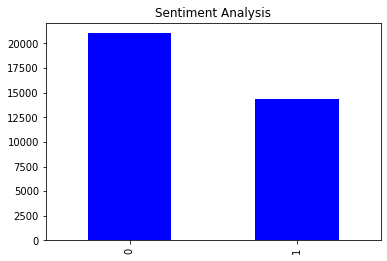

In [ ]:
df.sentiments.value_counts().plot(kind='bar',title="Sentiment Analysis",color="blue")

### **3. Machine Learning**

In [ ]:
df=pd.read_csv('LableReviews.csv',encoding='utf-8-sig')

In [ ]:
print("Dataset size:",df.comments.count())

#### **3.1. Naive Bayes**

In [ ]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,cohen_kappa_score

In [ ]:
np.random.seed(500) 

In [ ]:
Corpus =pd.read_csv('LableReviews.csv',encoding='utf-8-sig')
#comments--> dataset column name
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['comments'],Corpus['sentiments'],test_size=0.3)
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(Corpus['comments'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

**Naive** **Bayes** **Multinomial**

In [ ]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
predictions_NB = Naive.predict(Test_X_Tfidf)
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y))
print("Naive Bayes Precision Score -> ",precision_score(predictions_NB, Test_Y))
print("Naive Bayes Recall Score -> ",recall_score(predictions_NB, Test_Y))
print("Naive Bayes F1 Score -> ",f1_score(predictions_NB, Test_Y))
print("Naive Bayes Cohen's Kappa -> ",cohen_kappa_score(predictions_NB, Test_Y))

Naive Bayes Accuracy Score ->  0.7984751506024096
Naive Bayes Precision Score ->  0.7096085409252669
Naive Bayes Recall Score ->  0.765353121801433
Naive Bayes F1 Score ->  0.7364274282900406
Naive Bayes Cohen's Kappa ->  0.5736804927781658


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred=predictions_NB,y_true=Test_Y)
print('True Positives: ',cm[1,1])
print('False Positives: ',cm[0,1])
print('True Negatives: ',cm[0,0])
print('False Negatives: ',cm[1,0])

True Positives:  2991
False Positives:  917
True Negatives:  5492
False Negatives:  1224


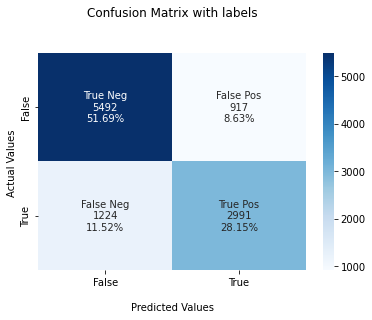

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

**Naive** **Bayes** **Bernoulli**


In [ ]:
Naive = naive_bayes.BernoulliNB()
Naive.fit(Train_X_Tfidf,Train_Y)
predictions_NB = Naive.predict(Test_X_Tfidf)
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y))
print("Naive Bayes Precision Score -> ",precision_score(predictions_NB, Test_Y))
print("Naive Bayes Recall Score -> ",recall_score(predictions_NB, Test_Y))
print("Naive Bayes F1 Score -> ",f1_score(predictions_NB, Test_Y))
print("Naive Bayes Cohen's Kappa -> ",cohen_kappa_score(predictions_NB, Test_Y))

Naive Bayes Accuracy Score ->  0.6760165662650602
Naive Bayes Precision Score ->  0.8752075919335706
Naive Bayes Recall Score ->  0.5585162755488267
Naive Bayes F1 Score ->  0.6818853974121997
Naive Bayes Cohen's Kappa ->  0.38304599189526567


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred=predictions_NB,y_true=Test_Y)
print('True Positives: ',cm[1,1])
print('False Positives: ',cm[0,1])
print('True Negatives: ',cm[0,0])
print('False Negatives: ',cm[1,0])

True Positives:  3689
False Positives:  2916
True Negatives:  3493
False Negatives:  526


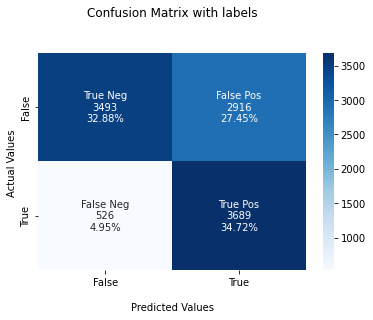

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

**Naive Bayes GaussianNB**

In [ ]:
Naive = naive_bayes.GaussianNB()
Naive.fit(Train_X_Tfidf.toarray(),Train_Y)
predictions_NB = Naive.predict(Test_X_Tfidf.toarray())
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y))
print("Naive Bayes Precision Score -> ",precision_score(predictions_NB, Test_Y))
print("Naive Bayes Recall Score -> ",recall_score(predictions_NB, Test_Y))
print("Naive Bayes F1 Score -> ",f1_score(predictions_NB, Test_Y))
print("Naive Bayes Cohen's Kappa -> ",cohen_kappa_score(predictions_NB, Test_Y))

Naive Bayes Accuracy Score ->  0.6223644578313253
Naive Bayes Precision Score ->  0.8813760379596679
Naive Bayes Recall Score ->  0.5140445551404456
Naive Bayes F1 Score ->  0.6493619996504107
Naive Bayes Cohen's Kappa ->  0.2970619958724984


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred=predictions_NB,y_true=Test_Y)
print('True Positives: ',cm[1,1])
print('False Positives: ',cm[0,1])
print('True Negatives: ',cm[0,0])
print('False Negatives: ',cm[1,0])

True Positives:  3715
False Positives:  3512
True Negatives:  2897
False Negatives:  500


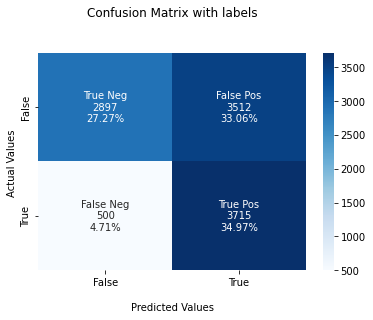

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

#### **3.2. SVM**

**SVM Polynomial**

In [ ]:
SVM = svm.SVC(C=1.0, kernel='poly', degree=3, gamma='scale')
SVM.fit(Train_X_Tfidf,Train_Y)
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y))
print("SVM  Precision Score -> ",precision_score(predictions_SVM, Test_Y))
print("SVM  Recall Score -> ",recall_score(predictions_SVM, Test_Y))
print("SVM  F1 Score -> ",f1_score(predictions_SVM, Test_Y))
print("SVM Cohen's Kappa -> ",cohen_kappa_score(predictions_SVM, Test_Y))

SVM Accuracy Score ->  0.8405496987951807
SVM  Precision Score ->  0.6635824436536181
SVM  Recall Score ->  0.9101854864952815
SVM  F1 Score ->  0.767563117453348
SVM Cohen's Kappa ->  0.6506940040474107


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred=predictions_SVM,y_true=Test_Y)
print('True Positives: ',cm[1,1])
print('False Positives: ',cm[0,1])
print('True Negatives: ',cm[0,0])
print('False Negatives: ',cm[1,0])

True Positives:  2797
False Positives:  276
True Negatives:  6133
False Negatives:  1418


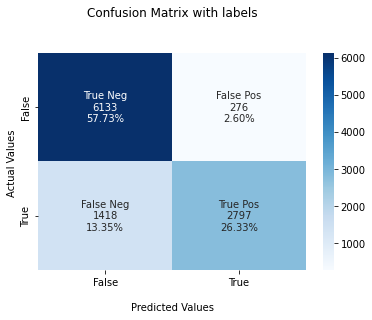

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

**SVM RBF**

In [ ]:
# Classifier - Algorithm - SVM
SVM = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='scale')
SVM.fit(Train_X_Tfidf,Train_Y)
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y))
print("SVM  Precision Score -> ",precision_score(predictions_SVM, Test_Y))
print("SVM  Recall Score -> ",recall_score(predictions_SVM, Test_Y))
print("SVM  F1 Score -> ",f1_score(predictions_SVM, Test_Y))
print("SVM Cohen's Kappa -> ",cohen_kappa_score(predictions_SVM, Test_Y))

SVM Accuracy Score ->  0.8724585843373494
SVM  Precision Score ->  0.8030842230130486
SVM  Recall Score ->  0.8657289002557544
SVM  F1 Score ->  0.8332307692307692
SVM Cohen's Kappa ->  0.7302123177663624


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred=predictions_SVM,y_true=Test_Y)
print('True Positives: ',cm[1,1])
print('False Positives: ',cm[0,1])
print('True Negatives: ',cm[0,0])
print('False Negatives: ',cm[1,0])

True Positives:  3385
False Positives:  525
True Negatives:  5884
False Negatives:  830


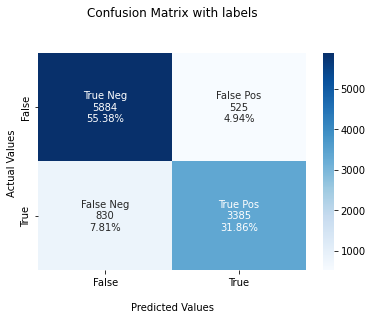

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

**SVM Sigmoid**

In [ ]:
# Classifier - Algorithm - SVM
SVM = svm.SVC(C=1.0, kernel='sigmoid', degree=3, gamma='scale')
SVM.fit(Train_X_Tfidf,Train_Y)
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y))
print("SVM  Precision Score -> ",precision_score(predictions_SVM, Test_Y))
print("SVM  Recall Score -> ",recall_score(predictions_SVM, Test_Y))
print("SVM  F1 Score -> ",f1_score(predictions_SVM, Test_Y))
print("SVM Cohen's Kappa -> ",cohen_kappa_score(predictions_SVM, Test_Y))

SVM Accuracy Score ->  0.6942771084337349
SVM  Precision Score ->  0.6308422301304863
SVM  Recall Score ->  0.6111238795679155
SVM  F1 Score ->  0.6208265234648611
SVM Cohen's Kappa ->  0.3648236449360194


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred=predictions_SVM,y_true=Test_Y)
print('True Positives: ',cm[1,1])
print('False Positives: ',cm[0,1])
print('True Negatives: ',cm[0,0])
print('False Negatives: ',cm[1,0])

True Positives:  2659
False Positives:  1692
True Negatives:  4717
False Negatives:  1556


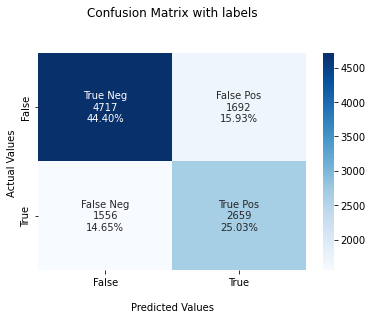

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

**SVM Linear**

In [ ]:
# Classifier - Algorithm - SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y))
print("SVM  Precision Score -> ",precision_score(predictions_SVM, Test_Y))
print("SVM  Recall Score -> ",recall_score(predictions_SVM, Test_Y))
print("SVM  F1 Score -> ",f1_score(predictions_SVM, Test_Y))
print("SVM Cohen's Kappa -> ",cohen_kappa_score(predictions_SVM, Test_Y))

SVM Accuracy Score ->  0.8278426204819277
SVM  Precision Score ->  0.7784104389086596
SVM  Recall Score ->  0.7856800766283525
SVM  F1 Score ->  0.7820283637230366
SVM Cohen's Kappa ->  0.6397763061807669


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred=predictions_SVM,y_true=Test_Y)
print('True Positives: ',cm[1,1])
print('False Positives: ',cm[0,1])
print('True Negatives: ',cm[0,0])
print('False Negatives: ',cm[1,0])

True Positives:  3281
False Positives:  895
True Negatives:  5514
False Negatives:  934


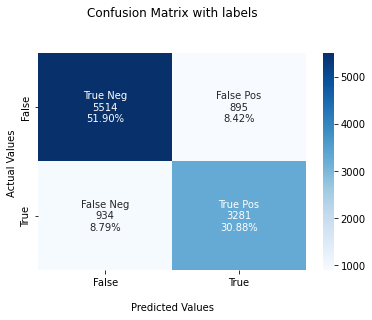

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

#### **3.3. RNN**

referans https://github.com/aaryaab/Text-Classification-with-RNN/blob/main/rnn_with_imdb.py

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM,  Dense, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [ ]:
df = pd.read_csv('LableReviews.csv',encoding='utf-8-sig')

In [ ]:
X = df.comments
Y = df.sentiments
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)
x_train,x_test, y_train, y_test = train_test_split(X,Y,test_size=0.30)

In [ ]:
words=20000
max_length=100
tok = Tokenizer(num_words=words)
tok.fit_on_texts(x_train)
sequences  = tok.texts_to_sequences(x_train)
sequences_matrix  = sequence.pad_sequences(sequences,maxlen=max_length)
word_size=words
embed_size=128

In [ ]:
model=tf.keras.Sequential()
# Embedding Layer
model.add(tf.keras.layers.Embedding(word_size, embed_size,input_length=max_length))
# LSTM Layer
model.add(tf.keras.layers.LSTM(units=128, activation='tanh'))
# Output Layer
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 128)          2560000   
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_length)
t = model.fit(sequences_matrix, y_train, epochs = 10, batch_size=64,validation_data=(test_sequences_matrix,y_test))
test_loss, test_acc = model.evaluate(test_sequences_matrix, y_test,verbose=2,batch_size=64)
print("Test accuracy: {}".format(test_acc))

Epoch 1/10
388/388 [==============================] - 135s 341ms/step - loss: 0.4482 - accuracy: 0.8039 - val_loss: 0.5136 - val_accuracy: 0.7935
Epoch 2/10
388/388 [==============================] - 117s 302ms/step - loss: 0.3176 - accuracy: 0.8624 - val_loss: 0.3798 - val_accuracy: 0.8427
Epoch 3/10
388/388 [==============================] - 126s 324ms/step - loss: 0.2771 - accuracy: 0.8818 - val_loss: 0.3424 - val_accuracy: 0.8542
Epoch 4/10
388/388 [==============================] - 123s 316ms/step - loss: 0.2439 - accuracy: 0.8998 - val_loss: 0.3352 - val_accuracy: 0.8658
Epoch 5/10
388/388 [==============================] - 119s 307ms/step - loss: 0.2158 - accuracy: 0.9128 - val_loss: 0.3312 - val_accuracy: 0.8575
Epoch 6/10
388/388 [==============================] - 125s 322ms/step - loss: 0.1911 - accuracy: 0.9246 - val_loss: 0.3478 - val_accuracy: 0.8678
Epoch 7/10
388/388 [==============================] - 124s 320ms/step - loss: 0.1727 - accuracy: 0.9334 - val_loss: 0.3404 -

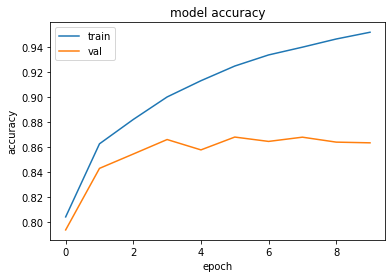

In [ ]:
from matplotlib import pyplot as plt
plt.plot(t.history['accuracy'])
plt.plot(t.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


referans: https://www.kaggle.com/egebasturk1/yemeksepeti-sentiment-analysis/data?select=lm.2gram.slm

In [ ]:
#confusion matrix
y_pred=model.predict(test_sequences_matrix,  batch_size=128, verbose=2, steps=None)
y_pred=y_pred>0.5
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,cohen_kappa_score
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred=y_pred,y_true=y_test)
print('True Positives: ',cm[1,1])
print('False Positives: ',cm[0,1])
print('True Negatives: ',cm[0,0])
print('False Negatives: ',cm[1,0])


83/83 - 20s - 20s/epoch - 237ms/step
True Positives:  3540
False Positives:  679
True Negatives:  5630
False Negatives:  775


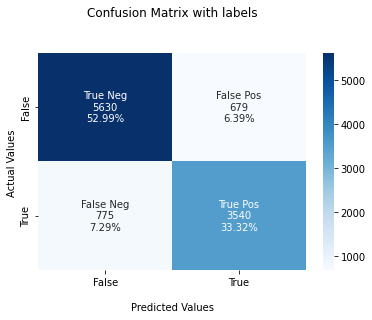

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
print("RNN Accuracy Score -> ",accuracy_score(y_test,y_pred))
print("RNN Precision Score -> ",precision_score(y_test,y_pred))
print("RNN Recall Score -> ",recall_score(y_test,y_pred))
print("RNN F1 Score -> ",f1_score(y_test,y_pred))
print("RNN Cohen's Kappa -> ",cohen_kappa_score(y_test,y_pred))

RNN Accuracy Score ->  0.8631400602409639
RNN Precision Score ->  0.8390613889547286
RNN Recall Score ->  0.8203939745075318
RNN F1 Score ->  0.8296226857276775
RNN Cohen's Kappa ->  0.715284748685869


#### **3.4. MLP**

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,cohen_kappa_score
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

In [ ]:
df=pd.read_csv('LableReviews.csv',encoding='utf-8-sig')
df = df[['comments', 'sentiments']]
df.columns = ['comments', 'sentiments']

In [ ]:
countvec = CountVectorizer(ngram_range=(1,4),strip_accents='unicode', max_features=2000)
X = df.comments.values
y = df.sentiments.values
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size = 0.3,   random_state = 0)
X_train = countvec.fit_transform(X_train.astype("str"))
X_test = countvec.transform(X_test.astype("str"))

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(400,400,100),activation = 'relu', verbose=False)
mlp.fit(X_train, y_train)
predictions_mlp = mlp.predict(X_test)

In [ ]:
print("MLP Accuracy Score -> ",accuracy_score(predictions_mlp, y_test))
print("MLP Precision Score -> ",precision_score(predictions_mlp, y_test))
print("MLP Recall Score -> ",recall_score(predictions_mlp, y_test))
print("MLP F1 Score -> ",f1_score(predictions_mlp, y_test))
print("MLP Cohen's Kappa -> ",cohen_kappa_score(predictions_mlp,y_test))

MLP Accuracy Score ->  0.8607868975903614
MLP Precision Score ->  0.8229287537711766
MLP Recall Score ->  0.8320037541060535
MLP F1 Score ->  0.8274413720686035
MLP Cohen's Kappa ->  0.7107792706825757


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred=predictions_mlp,y_true=y_test)
print('True Positives: ',cm[1,1])
print('False Positives: ',cm[0,1])
print('True Negatives: ',cm[0,0])
print('False Negatives: ',cm[1,0])

True Positives:  3546
False Positives:  716
True Negatives:  5599
False Negatives:  763


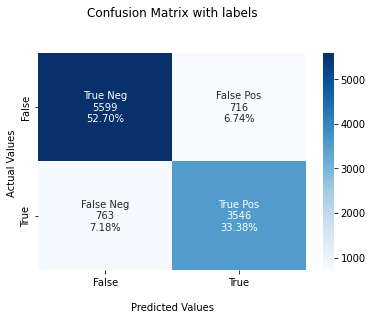

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()